## Predizendo número de suicídios a partir de variáveis econômicas

Utilizando a extração de dados que realizamos [aqui](https://github.com/GabrielReisR/suicide_in_brazil/blob/main/data/getting_pysus_data_2010_2019.ipynb), vamos agora tentar predizer número de suicídios a partir de variáveis econômicas. As variáveis escolhidas foram:

- Taxa de inflação (mensal)
- Salário mínimo (mensal)
- Massa salarial ampliada (mensal)
- Estoque de empregos em saúde (mensal)
- Dívida líquida do setor público em milhões (mensal)
- Indicador de tendência de preços de imóveis (mensal)

Taxa de inflação, salário mínimo e massa salarial ampliada estão relacionadas a indicadores econômicos importantes relacionadas à poder de compra e possibilidade de renda. Estoque de empregos em saúde pode estar relacionada à disponibilidade de serviços de saúde para a população. Dívida líquida do setor público é uma variável macroeconômica relacionada às dívidas da União. Enquanto isso, o indicador de tendência de preços de imóveis estão relacionadas ao aumento ou à diminuição dos valores de imóveis no Brasil - o que pode estar relacionado a boas condições de moradia.

A variável desfecho é o número de mortes por suicídio no Brasil (mensal).

### Inicializando

In [1]:
# Standard libraries and plot modules
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as random
import seaborn as sns
import warnings
from sklearn.exceptions import DataConversionWarning
%config Completer.use_jedi = False # this speeds up autocomplete

In [2]:
# Preprocessing and data preparation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
from sklearn.model_selection import train_test_split

# Algorithms
## Linear models
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor

## Kernels
from sklearn.kernel_ridge import KernelRidge

## Support Vector Machines
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVR
from sklearn.svm import SVR

## Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

## Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor

## Cross decomposition
from sklearn.cross_decomposition import PLSRegression

## Decision trees
from sklearn.tree import DecisionTreeRegressor

## Ensemble methods
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

## Isotonic regression
from sklearn.isotonic import IsotonicRegression

## Neural network
from sklearn.neural_network import MLPRegressor

# Cross-validation
from sklearn.model_selection import GridSearchCV

# Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Feature importance
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
import session_info
session_info.show(dependencies = False)

#### Session Information
- eli5                0.11.0
- matplotlib          3.3.3
- numpy               1.19.5
- pandas              1.2.1
- seaborn             0.11.1
- session_info        1.0.0
- sklearn             0.24.1
- IPython             7.19.0
- jupyter_client      6.1.11
- jupyter_core        4.7.0
- notebook            6.2.0
- Python 3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]
- Windows-10-10.0.19041-SP0
- Session information updated at 2021-10-26 01:54

### Lendo o banco de dados

In [4]:
df = pd.read_csv('../data/monthly_total.csv', index_col = 0)
df = df.set_index('index') # organizando index
print(df.head())
print(df.tail())

              n
index          
2010-01-01  851
2010-02-01  726
2010-03-01  803
2010-04-01  757
2010-05-01  810
               n
index           
2019-08-01  1107
2019-09-01  1176
2019-10-01  1136
2019-11-01  1152
2019-12-01  1189


### Baixando dados socioeconômicos (de 2010-01-01 até 2019-12-01)

In [5]:
'''
Code from: https://www.youtube.com/watch?v=7rFsu48oBn8&list=PLCAhGm8nJ9CBn51o0x3j1p1LuMRqpeqCy
I added the arguments 'data_inicio' and 'data_final' to help filtering the data.
''' 

# Creating scraping code
def consulta_bc(codigo_bcb, data_inicio = '2010-01-01', data_final = '2019-12-31'):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  df.index.rename('index', inplace=True)
  df = df[df.index >= data_inicio]
  return df[df.index < data_final]

In [6]:
# Inflação
ipca = consulta_bc(433)

In [7]:
# Salário mínimo
salario_minimo = consulta_bc(1619)

In [8]:
# Massa salarial ampliada
msa = consulta_bc(22078)

In [9]:
# Estoque de empregos em saúde
estoque_empregos_saude = consulta_bc(28782)

In [10]:
# Dívida líquida do setor público em milhões
divida_liquida = consulta_bc(4468)

In [11]:
# Indicador de tendência de preços de imóveis
mvg_r = consulta_bc(25419)

### Juntando os dados

In [12]:
df['ipca'] = ipca['valor'].to_list()
df['salario_minimo'] = salario_minimo['valor'].to_list()
df['msa'] = msa['valor'].to_list()
df['estoque_empregos_saude'] = estoque_empregos_saude['valor'].to_list()
df['divida_liquida'] = divida_liquida['valor'].to_list()
df['mvg_r'] = mvg_r['valor'].to_list()
df

,n,ipca,salario_minimo,msa,estoque_empregos_saude,divida_liquida,mvg_r
index,,,,,,,
2010-01-01,851,0.75,510.0,135781.9,1535194,903896.84,84000
2010-02-01,726,0.78,510.0,135612.4,1542691,926827.67,85000
2010-03-01,803,0.52,510.0,132378.3,1550046,948069.64,87012
2010-04-01,757,0.57,510.0,134216.8,1562634,951442.44,88000
2010-05-01,810,0.43,510.0,135625.4,1573338,948538.76,89070
...,...,...,...,...,...,...,...
2019-08-01,1107,0.11,998.0,298605.9,2341763,2903771.35,183500
2019-09-01,1176,-0.04,998.0,306757.0,2349761,2944328.62,185000
2019-10-01,1136,0.10,998.0,306844.3,2354741,3003316.76,180000


### Explorações iniciais da distribuição

#### Número de suicídio ao longo dos anos

<AxesSubplot:xlabel='index'>

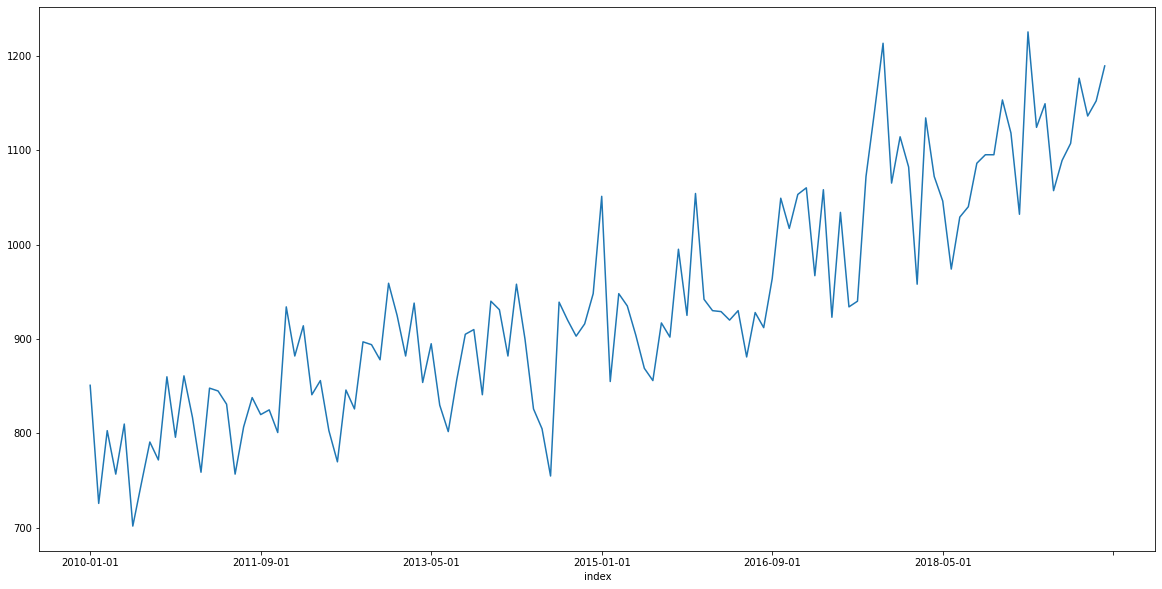

In [35]:
df['n'].plot(figsize = (20, 10))

O número de suicídios ao longo dos anos vem aumentando, constituindo um grave problema de saúde pública. Para análises mais detalhadas:

- [Análise exploratórias detalhadas](https://rpubs.com/reisrgabriel/suicides_in_brazil)
- [Post no Medium](https://medium.com/psicodata/suicidios-no-brasil-de-2010-a-2019-9469655b1269?source=friends_link&sk=307564dff2ca9a053ce31097841e520d)
- [Publicação com R no Kaggle](https://www.kaggle.com/psicodata/visualiza-es-iniciais)

#### Histogramas iniciais

array([[<AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'ipca'}>,
        <AxesSubplot:title={'center':'salario_minimo'}>],
       [<AxesSubplot:title={'center':'msa'}>,
        <AxesSubplot:title={'center':'estoque_empregos_saude'}>,
        <AxesSubplot:title={'center':'divida_liquida'}>],
       [<AxesSubplot:title={'center':'mvg_r'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

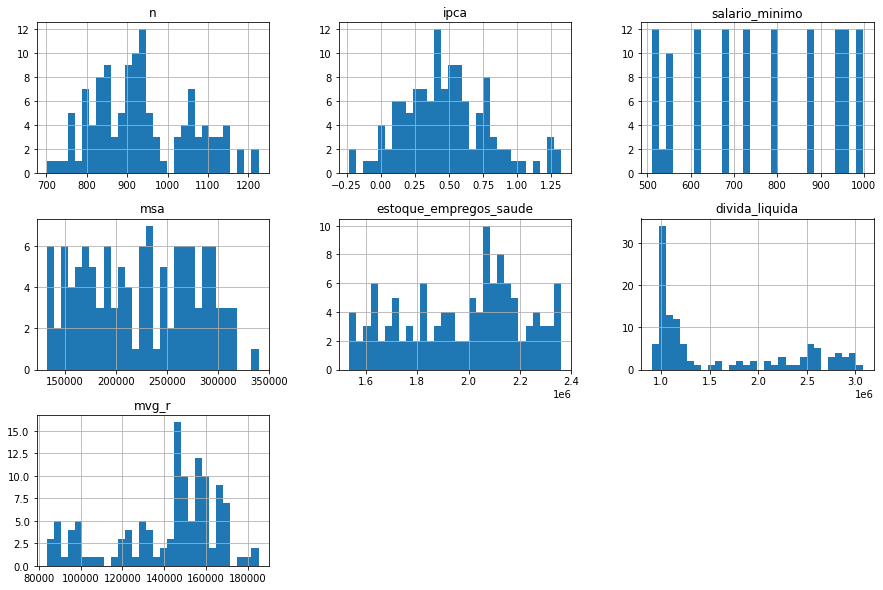

In [13]:
df.hist(bins=30, figsize=(15,10))

Percebe-se grande flutuação envolvendo todas as variáveis, além de falta de normalidade em todas elas. Valores constantes de *salario_minimo* podem comprometer o desempenho da análise adiante.

#### Mudança percentual ao longo do tempo

<AxesSubplot:xlabel='index'>

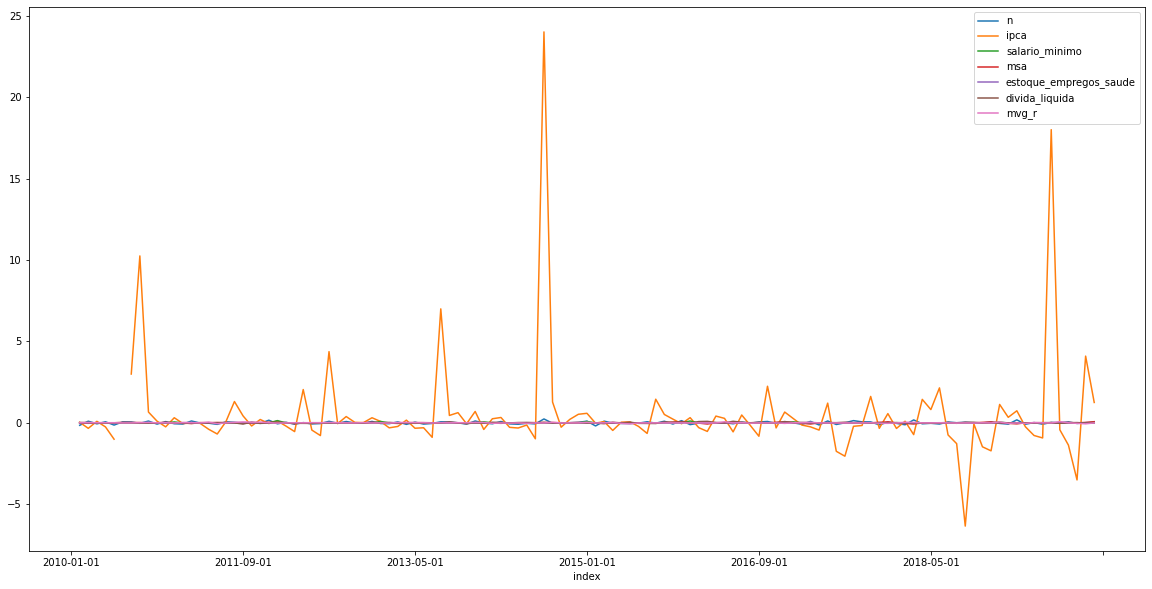

In [14]:
df.pct_change().plot(figsize = (20, 10))

Massa salarial ampliada (*msa*) foi nossa variável com maior variação durante esse tempo. Vamos agora investigar associações lineares entre as variáveis.

### Explorando associação dos dados

<AxesSubplot:>

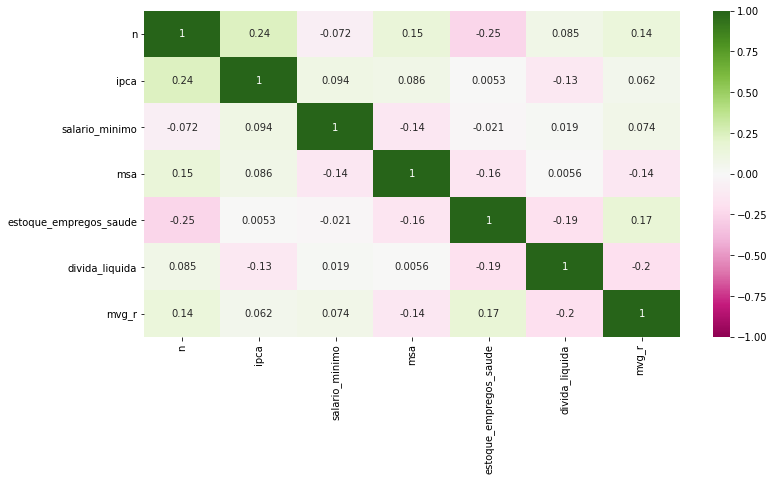

In [15]:
matplotlib.rcParams['figure.figsize'] = (12, 6)

# Creating correlation
corr = df.pct_change().corr('spearman')

# With values
sns.heatmap(corr, 
            vmin = -1, vmax = 1,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            cmap = "PiYG",
            annot = True # this argument must be 'False'
           )

Número de mortes por suicídio (*n*) parece estar linearmente associada a inflação (relação positiva e fraca) e à estoque de empregos na área da saúde (relação negativa e fraca). Mais adiante, vamos entender quais variáveis foram mais poderosas na predição do número de suicídios.

### Preparando função para ML

Agora vamos criar uma função para comparar diversos modelos de regressão. Essa função vai utilizar todos os algoritmos presentes no [scikit-learn](https://scikit-learn.org/). A função `run_ml()` vai criar 10 diferentes bancos de dados que serão analisados pelos algoritmos escolhidos do scikit-learn.

**Objetivo de `run_ml()`**

1. Comparação de diversos modelos de machine learning ao mesmo tempo. Se um modelo for muito bom, podemos seguir as análises com ele e ir mais a fundo nos seus parâmetros.
2. Criar diferentes modelos diferentes vezes (10 vezes) para que tenhamos a média de acerto de um modelo (sem um possível erro de comparação).
3. Ter uma base de erro mínimo a ser batida para um modelo simples de deep learning, também usando scikit-learn.

**Etapas de `run_ml()`**

1. Inicialização de um for loop.
2. O algoritmo recebe os bancos X (todos features) e Y (valores da variável desfecho) e divide os valores desses bancos de dados em outros 4: X_train, X_test, Y_train e Y_test.
3. Os algoritmos treinam com X_train e Y_train. Os valores de erro são armazenados em um banco de dados inicializados anteriormente à função `run_ml()`.
4. Os algoritmos testam suas predições com X_test e Y_test. Os valores de erro são armazenados em um banco de dados inicializados anteriormente à função `run_ml()`.
5. Retornamos ao início do for loop. As etapas 2 a 4 se repetirão 100 vezes (ou quantas desejarmos, definindo-se isso pelo argumento *k*).

Ao final, teremos *k* resultados diferentes dos modelos. Para comparar os modelos, faremos a média de erro que cada modelo conseguiu ter. Se quisermos resultados mais estáveis, devemos aumentar o número de repetições que teremos no nosso código. Além disso, para garantir a reprodutibilidade, as bases de dados são criadas usando o *random_state* do número atual da repetição do *for_loop*. Ou seja, a base 1 será sempre a base 1, a base 2 será sempre a base 2, e assim por diante.

In [16]:
MLA = [
    
    # Linear models
    ARDRegression(),
    BayesianRidge(),
    ElasticNetCV(),
    HuberRegressor(),
    LassoCV(),
    LassoLars(alpha =.1),
    LinearRegression(),
    MultiTaskLasso(alpha =.1),
    PassiveAggressiveRegressor(),
    Ridge(alpha =.5),
    RidgeCV(),
    SGDRegressor(),
    TheilSenRegressor(),
    RANSACRegressor(min_samples=1),

    # Kernels
    KernelRidge(),
    
    # Support Vector Machines
    LinearSVR(),
    NuSVR(),
    SVR(),
    
    # Nearest Neighbors
    KNeighborsRegressor(),
    
    # Gaussian processes
    GaussianProcessRegressor(),
    
    # Cross decomposition
    PLSRegression(n_components=5),
    
    # Decision trees
    DecisionTreeRegressor(),
    
    # Ensemble methods
    AdaBoostRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    HistGradientBoostingRegressor(),
    RandomForestRegressor()
]

In [25]:
# Preparing hyperparameters
#MLA_columns = []
#MLA_compare = pd.DataFrame(columns = MLA_columns)

'''
This code was initially built by Dalton Costa (https://www.linkedin.com/in/dalton-breno-costa-33303313a/)
It was initially built to compare several classification algorithms
Gabriel Rodrigues (https://reisrgabriel.com) has made several changes to the 
original code, altering the aim from classification to regression.
However, the structure remains the same as it was originally conceived by Dalton.
'''

def run_ml(k = 100):
    # Getting rid of warnings
    pd.options.mode.chained_assignment = None # remove warning message
    warnings.filterwarnings(action = 'ignore', category = DataConversionWarning)

    # Start of function:
    print("Running...")
    MLA_columns = []
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    row_index = 0

    for _ in range(k): # Code will run 10 times, creating 10 different datasets

        for alg in MLA:
            
            # Create a X and Y train/test datasets
            X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                                test_size = 0.20,
                                                                random_state = _)
            
            # Normalize features in X_train and X_test
            X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
            X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

            # Run algorithms in MLA list
            train = alg.fit(X_train, y_train)
            predicted = train.predict(X_test)

            # Organizing pd.DataFrame 'MLA_compare'
            MLA_name = alg.__class__.__name__

            MLA_compare.loc[row_index,
                            'MLA Name'] = MLA_name

            # Training metrics
            MLA_compare.loc[row_index,
                            'Mean Train Score'] = round(alg.score(X_train, y_train), 4)

            MLA_compare.loc[row_index,
                            'Train MSE'] = round(mean_squared_error(y_train, train.predict(X_train)), 4)
            
            MLA_compare.loc[row_index,
                            'Train R Squared'] = round(r2_score(y_train, train.predict(X_train)), 4)

            MLA_compare.loc[row_index,
                            'Train MAE'] = round(mean_absolute_error(y_train, train.predict(X_train)), 4)
            
            # Test metrics
            MLA_compare.loc[row_index,
                            'Mean Test Score'] = round(alg.score(X_test, y_test), 4)

            MLA_compare.loc[row_index,
                            'Test MSE'] = round(mean_squared_error(y_test, train.predict(X_test)), 4)
            
            MLA_compare.loc[row_index,
                            'Test R Squared'] = round(r2_score(y_test, train.predict(X_test)), 4)

            MLA_compare.loc[row_index,
                            'Test MAE'] = round(mean_absolute_error(y_test, train.predict(X_test)), 4)

            
            #print(row_index)
            #print(MLA_compare['MLA Name'])

            # Training
            #print(MLA_compare['Mean Train Score'])
            #print(MLA_compare['Train MSE'])
            #print(MLA_compare['Train R Squared'])
            #print(MLA_compare['Train MAE'])

            # Test
            #print(MLA_compare['Mean Test Score'])
            #print(MLA_compare['Test MSE'])
            #print(MLA_compare['Test R Squared'])
            #print(MLA_compare['Test MAE'])

            row_index+=1
    
    print("Finished!")
    
    mean = MLA_compare.groupby(['MLA Name']).mean()
    mean = mean.sort_values(by = ['Test MAE'], ascending = True)
    
    return(mean)

### Criação do banco de dados X e Y

In [18]:
# Selecting X features and dependent variable Y
X = df.drop(columns = 'n')
y = df[['n']]

### Rodando `run_ml()`

**Importante**: como a função tem o intuito de fornecer valores de treino e teste randômicos aos algoritmos, a cada rodada novos valores de erro serão alcançados. Isso é comum e faz parte do código. Por ter 100 repetições, o código pode demorar um pouco para rodar.

In [26]:
run_ml(k = 100)

Running...
Finished!


,Mean Train Score,Train MSE,Train R Squared,Train MAE,Mean Test Score,Test MSE,Test R Squared,Test MAE
MLA Name,,,,,,,,
LinearRegression,0.836663,2326.708091,0.836663,37.062976,0.736435,3448.827341,0.736435,45.811958
Ridge,0.835134,2348.505321,0.835134,37.451804,0.738368,3427.824433,0.738368,45.836438
PLSRegression,0.836264,2332.417862,0.836264,37.256348,0.737426,3438.694887,0.737426,45.851239
MultiTaskLasso,0.836455,2329.718117,0.836455,37.186519,0.736536,3448.970421,0.736536,45.887367
HuberRegressor,0.835500,2343.261573,0.835500,36.810253,0.736599,3442.742090,0.736599,45.905434
TheilSenRegressor,0.829850,2423.942167,0.829850,36.970804,0.732242,3507.880059,0.732242,45.994100
BayesianRidge,0.833450,2372.512970,0.833450,37.702590,0.736318,3455.629102,0.736318,46.090263
RidgeCV,0.834847,2352.963810,0.834847,37.439065,0.734373,3478.802408,0.734373,46.136597
LassoCV,0.834463,2358.128866,0.834463,37.507617,0.732631,3502.890463,0.732631,46.355060


Dessa vez um modelo linear tomou a frente! A boa e velha regressão linear, ou [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) teve o menor erro, em média, nas nossas bases de teste. É importante atentar que os piores modelos são consistentemente piores, porém os melhores modelos possuem uma variabilidade considerável dependendo do *random_state* e número de repetições. Nesse sentido, quanto maior o número de repetições maior a estabilidade dos melhores modelos.

### Rodando Neural Networks

Podemos também rodar um modelo simples de deep learning e analisar o quanto ele melhora na predição de número de suicídios em relação ao nosso melhor algoritmo anterior. Assim, caso nosso modelo de deep learning tenha um MAE < 45.49 na nossa base de teste, ele parece estar mais acurado nessa predição. Se isso acontecer, ele será nosso modelo final.

#### Preparando banco de dados

In [28]:
pd.options.mode.chained_assignment = None # remove warning message

# Selecting X features and dependent variable Y
X = df.drop(columns = 'n')
y = df[['n']]

# Creating X and y train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    random_state = 42)


# Normalizing features in X_train and X_test
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

# Normalizing target variable
y_train[y_train.columns] = scaler.fit_transform(y_train[y_train.columns])
y_test[y_test.columns] = scaler.fit_transform(y_test[y_test.columns])

### Cross-validation

Na cross-validation, nós vamos alimentar um modelo com diversos parâmetros possíveis. Ele vai testar todos esses modelos, armazenar o resultado de cada um, e nos dizer quais parâmetros geram o modelo com menos erro.

In [29]:
# Creating param_grid
param_grid = {"hidden_layer_sizes": [(1,),(100,)],
              "activation": ["identity", "logistic", "tanh", "relu"],
              "solver": ["lbfgs", "sgd", "adam"],
              "alpha": [0.00005,0.0005],
              "learning_rate": ['constant', 'invscaling', 'adaptive'],
              "learning_rate_init": [0.000001, 0.001]
             }

# Cross-validation - searching the best hyperparameters
clf = GridSearchCV(MLPRegressor(max_iter = 50000,
                                random_state = 42),
                   param_grid = param_grid)

clf.fit(X_train, y_train.values.ravel())

print("Training set score: %f" % clf.score(X_train, y_train))
print("Test set score: %f" % clf.score(X_test, y_test))

print("Best parameters set found on development set:")
print(clf.best_params_)

Training set score: 0.836989
Test set score: 0.852058
Best parameters set found on development set:
{'activation': 'logistic', 'alpha': 0.0005, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'learning_rate_init': 1e-06, 'solver': 'lbfgs'}


Agora, vamos utilizar todos esses parâmetros abaixo para a criação do nosso modelo!

### Rodando a neural network

In [30]:
neural_network = MLPRegressor(hidden_layer_sizes = 1, # 50 works better for some reason
                              activation = 'logistic',
                              alpha = 0.0005,
                              learning_rate = 'constant',
                              learning_rate_init = 1e-06,
                              max_iter = 50000,
                              solver = 'lbfgs',
                              random_state = 42).fit(X_train, y_train.values.ravel())

# Train
print('TRAIN SCORES\n')
print('Train score:', round(neural_network.score(X_train, y_train), 4))
print('Train Mean Squared Error:', round(mean_squared_error(y_train, neural_network.predict(X_train)), 4))
print('Train Mean Absolute Error:', round(mean_absolute_error(y_train, neural_network.predict(X_train)), 4))

# Test
print('\nTEST SCORES\n')
print('Test score:', round(neural_network.score(X_test, y_test), 4))
print('Test Mean Squared Error:', round(mean_squared_error(y_test, neural_network.predict(X_test)), 4))
print('Test Mean Absolute Error:', round(mean_absolute_error(y_test, neural_network.predict(X_test)), 4))

TRAIN SCORES

Train score: 0.837
Train Mean Squared Error: 0.163
Train Mean Absolute Error: 0.3086

TEST SCORES

Test score: 0.8521
Test Mean Squared Error: 0.1479
Test Mean Absolute Error: 0.3135


Nosso MAE passou de 45.81 da regressão linear para 0.31 com um modelo bem simples de rede neural! Uma melhoria absurda!

### Feature importance

**Afinal, qual variável impacta a previsão de número de mortes causadas por suicídio?**

Como um modelo de neural network é considerado um modelo de black box, nós não conseguimos acessar os parâmetros precisos de cada camada de neurônio. Entretanto, conseguimos com tranquilidade dizer quais os melhores parâmetros para predição do modelo. Isso será feito com o [ELI5](https://eli5.readthedocs.io/en/latest/overview.html) utilizando um modelo de permutação conhecido como [PermutationImportance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html).

<AxesSubplot:title={'center':'Feature importance arranged by MAE reduction in a prediction without the feature'}, ylabel='feature'>

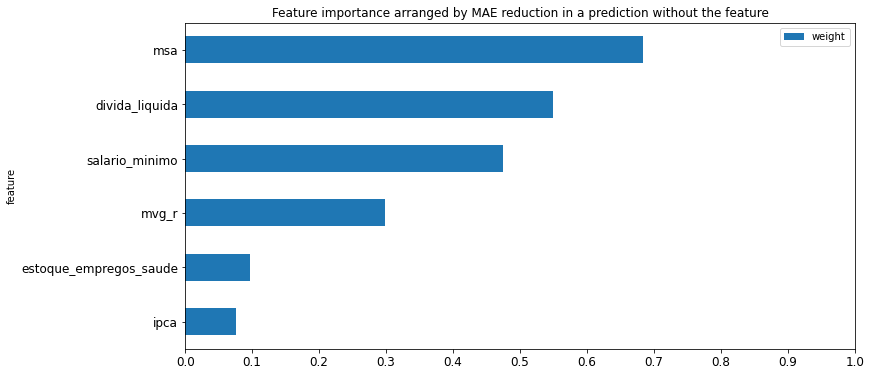

In [40]:
perm = PermutationImportance(neural_network,
                             scoring = 'neg_mean_absolute_error',
                             random_state = 42).fit(X_test, y_test)

# Cria pandas.DataFrame com feature importances
feature_importance = eli5.explain_weights_df(perm,
                                             feature_names = X_test.columns.to_list())

# Ajusta ordem do plot
matplotlib.rcParams['figure.figsize'] = (12, 6)

feature_importance.sort_values('weight', inplace = True)

feature_importance.plot(kind = 'barh',
                        x = 'feature',
                        y = 'weight',
                        xlim = (0, 1),
                        title = 'Feature importance arranged by MAE reduction in a prediction without the feature',
                        xticks = [0, 0.10, 0.2, 0.3, 0.4, 0.5, 
                                  0.6, 0.70, 0.80, 0.9, 1],
                        fontsize = 12)

No geral, a variável com maior impacto foi massa salarial ampliada (MSA), seguido por dívida líquida e valor do salário mínimo. Com exceção de dívida líquida, massa salarial ampliada e salário mínimo refletem o repasse governamental de valores de previdência (MSA) e um valor base para recebimento de salários nas organizações (salário mínimo). O que possuem em comum parece ser o investimento dado pelo governo ao trabalho.

### Erros da Neural Network

É importante salientar que fizemos transformações nos nossos dados ao rodar os modelos - assim, as previsões dadas são baseadas nessas transformações. A transformação escolhida foi em escore *z* - os valores preditos, portanto, são baseados nesse escore. Isso é importante para a interpretação que faremos a seguir.

Text(0.5, 0, 'Errors in Standard Deviations Made by Neural Network')

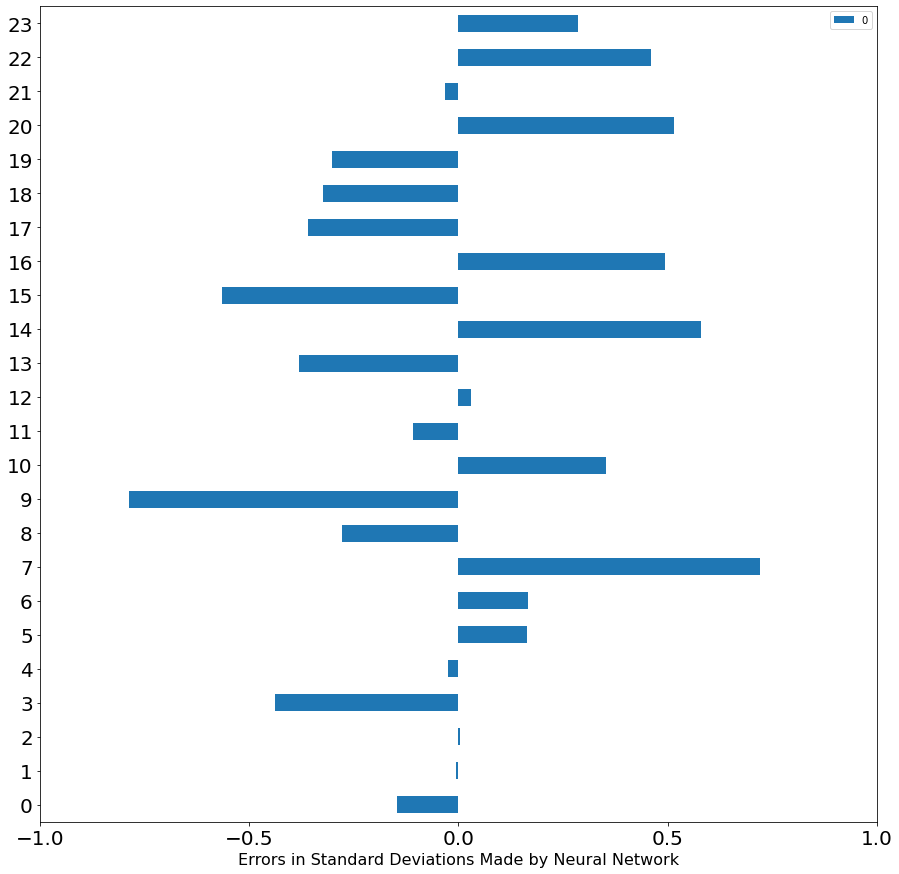

In [42]:
# How many errors?
# Subtracting predicted value by target value
errors = neural_network.predict(X_test) - y_test.values.ravel()

# Plotting prediction error made by neural network
pd.DataFrame(errors).plot(figsize=(15,15),kind = 'barh',
                              xlim = (-1, 1),
                              #xlabel = 'Errors in Standard Deviations Made by Neural Network',
                              xticks = [-1, -0.5, 0, 0.5, 1],
                              fontsize = 20)

plt.xlabel('Errors in Standard Deviations Made by Neural Network', fontsize=16)

Em média, tivemos erros de escores *z* entre -0.9 e 0.9. Isso é *muito* bom! Significa que, em média, erramos menos de 1 desvio-padrão em relação à nossa variável desfecho. Fizemos uma previsão bem próxima ao nosso valor final. O modelo de rede neural realmente foi bem poderoso nesse caso, especialmente nos valores 1, 2, 4, 12 e 21, que tiveram erros menores que 0.2.

### Contato

**Por hoje era isso! Quer falar comigo?**

- Para falar comigo, é só entrar em [qualquer um desses links](https://linktr.ee/gabrielrr).
- Você também pode acessar [meu site](https://reisrgabriel.com/) se quiser ver meu currículo completo e outras informações.